<a href="https://colab.research.google.com/github/violentdelight/Deep-Colorization/blob/master/Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

Using TensorFlow backend.


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 0qADtP.jpg to 0qADtP.jpg
Saving 1PFDZe.jpg to 1PFDZe.jpg
Saving 8ntGqA.jpg to 8ntGqA.jpg
Saving 8oZO2i.jpg to 8oZO2i.jpg
Saving 8X0jDX.jpg to 8X0jDX.jpg
Saving 9KkoOf.jpg to 9KkoOf.jpg
Saving 11Se02.jpg to 11Se02.jpg
Saving 27gIpN.jpg to 27gIpN.jpg
Saving 29Pkqp.jpg to 29Pkqp.jpg
Saving 30gdlQ.jpg to 30gdlQ.jpg
User uploaded file "0qADtP.jpg" with length 32294 bytes
User uploaded file "1PFDZe.jpg" with length 49755 bytes
User uploaded file "8ntGqA.jpg" with length 60791 bytes
User uploaded file "8oZO2i.jpg" with length 36550 bytes
User uploaded file "8X0jDX.jpg" with length 52706 bytes
User uploaded file "9KkoOf.jpg" with length 45137 bytes
User uploaded file "11Se02.jpg" with length 60073 bytes
User uploaded file "27gIpN.jpg" with length 49376 bytes
User uploaded file "29Pkqp.jpg" with length 70967 bytes
User uploaded file "30gdlQ.jpg" with length 59669 bytes


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


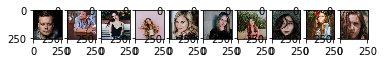

In [0]:
from PIL import Image
from numpy import array
import io
import matplotlib.pyplot as plt
%matplotlib inline

# image_data = uploaded['100_256.jpg'] # byte values of the image
# image = Image.open(io.BytesIO(image_data))
# arr = array(image, 'float')/255
# print(arr.dtype)

X = []
i=1
for f in uploaded:
    image_data = uploaded[f] # byte values of the image
    image = Image.open(io.BytesIO(image_data))
    plt.subplot(1, len(uploaded), i)
    plt.imshow(image)
    arr = array(image)
    print(arr.shape)
    X.append(arr)
    i +=1

In [0]:
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = np.array( Xtrain, dtype=float )
Xtrain = 1.0/255*Xtrain
print(Xtrain.shape)
# array_to_img(Xtrain[1,:,:,:])

#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

(9, 256, 256, 3)
Instructions for updating:
Colocations handled automatically by placer.
225214464/225209952 [==============================] - 5s 0us/step


In [0]:
embed_input = Input(shape=(1000,))
print(embed_input.shape)

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
print(encoder_output.shape)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
print(encoder_output.shape)

encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
print(encoder_output.shape)

encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
print(encoder_output.shape)

encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
print(encoder_output.shape)

encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
print(encoder_output.shape)

encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
print(encoder_output.shape)

encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
print(encoder_output.shape)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)


(?, 1000)
(?, 128, 128, 64)
(?, 128, 128, 128)
(?, 64, 64, 128)
(?, 64, 64, 256)
(?, 32, 32, 256)
(?, 32, 32, 512)
(?, 32, 32, 512)
(?, 32, 32, 256)


In [0]:
model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 128, 128, 128 73856       conv2d_204[0][0]                 
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 64, 64, 128)  147584      conv2d_205[0][0]                 
__________________________________________________________________________________________________
conv2d_207

In [0]:
#Create embedding
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 20

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)

#Train model      
tensorboard = TensorBoard(log_dir="/output")
model.compile(optimizer='adam', loss='mse')
model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard], epochs=100, steps_per_epoch=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


20/20 [==============================] - 27s 1s/step - loss: 0.0284
Epoch 2/100
20/20 [==============================] - 18s 879ms/step - loss: 0.0059
Epoch 3/100
20/20 [==============================] - 17s 859ms/step - loss: 0.0056
Epoch 4/100
20/20 [==============================] - 18s 877ms/step - loss: 0.0055
Epoch 5/100
20/20 [==============================] - 17s 842ms/step - loss: 0.0052
Epoch 6/100
20/20 [==============================] - 17s 840ms/step - loss: 0.0049
Epoch 7/100
20/20 [==============================] - 17s 838ms/step - loss: 0.0048
Epoch 8/100
20/20 [==============================] - 17s 842ms/step - loss: 0.0047
Epoch 9/100
20/20 [==============================] - 17s 874ms/step - loss: 0.0045
Epoch 10/100
20/20 [==============================] - 17s 841ms/step - loss: 0.0043
Epoch 11/100
20/20 [==============================] - 17s 842ms/step - loss: 0.0042
Epoch 12/100
20/20 [==============================] - 17s 842ms/step - loss: 0.0040
Epoch 13/100
20/

In [0]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("color_tensorflow_real_mode.h5")
saver = tf.train.Saver()

In [0]:
test = files.upload()

for fn in test.keys():    
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(test[fn])))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


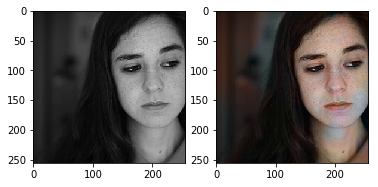

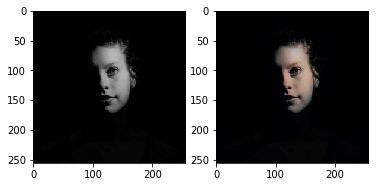

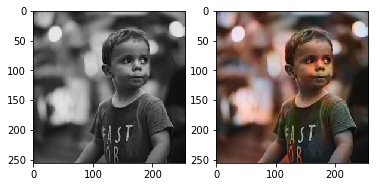

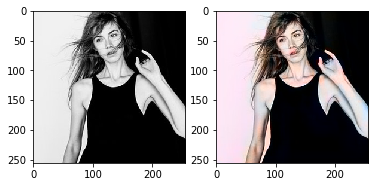

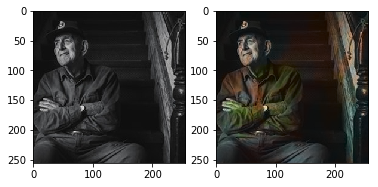

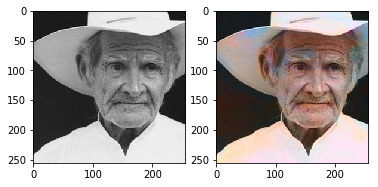

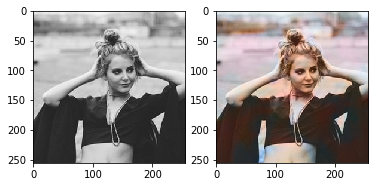

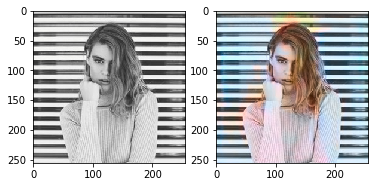

In [0]:
i=1
color_me = []
for f in test:
    image_data = test[f] # byte values of the image    
    image = Image.open(io.BytesIO(image_data))
    arr = array(image)
    color_me.append(arr)
    i +=1

given_im = list(color_me)
color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
color_me = gray2rgb(rgb2gray(color_me)) # Leaves the dark features
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

#Output colorizations
for i in range(0,len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = (color_me[i][:,:,0])
    cur[:,:,1:] = output[i]
    fig = plt.figure()
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(given_im[i])

    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(lab2rgb(cur))

    plt.show()